# Text generation with deep learning

In [3]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy
import unidecode

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets



%matplotlib inline


from bokeh.io import show,output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
from bokeh.models import FuncTickFormatter
from bokeh.plotting import figure

output_notebook()

/home/habkaffee/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

Определим структуру сети, в качестве основного блока используем **GRU**

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

# Пример реализации класса для получения данных из датасета

In [5]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=10, chunks_number=100):
        self.chunks_number = chunks_number
        self.chunk_len = chunk_len
        self.text = text
        self.all_symbols = list({x for x in self.text})
    
    def __len__(self):
        return self.chunks_number
    
    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

# Здесь должен быть код для считывания данных и создания даталоадера

In [4]:
dataset = pd.read_csv('data/arxiv.csv')
all_texts = ''.join(x for x in dataset['summary'])
all_texts = unidecode.unidecode(all_texts)
arxiv_dataset = TextDataset(text=all_texts)

loader = DataLoader(arxiv_dataset)

Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [5]:
unique_symbols = len(arxiv_dataset.all_symbols)
n_layers = 2
hidden_size = 100

In [6]:
unique_symbols

97

In [7]:
print(arxiv_dataset.all_symbols)

['I', '<', 's', '8', '\\', 'G', 'z', 'y', 'w', ' ', '!', '(', '>', 'A', 'W', '3', 'c', 'n', 'H', ':', 'p', ';', 'E', ']', 'f', '^', '~', 'i', '_', 't', 'V', '1', 'e', '6', '}', '5', '[', '#', '$', 'b', '*', 'd', 'P', 'K', '2', 'k', 'l', '?', 'Z', '%', 'm', 'u', 'S', "'", '4', 'Y', 'D', 'U', 'F', 'O', ')', '0', 'v', '+', 'C', 'q', '=', '\x7f', '`', 'Q', 'X', '"', 'L', 'J', '/', 'r', 'a', '-', 'j', '&', '{', 'M', 'g', '@', 'B', '\n', '|', 'N', 'h', 'x', 'T', '9', 'R', '.', ',', 'o', '7']


In [8]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [9]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
device = torch.device("cuda")

net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

# Здесь нужно реализовать функцию для генерации текста с помощью сети

In [20]:
def random_sample(dataset:TextDataset):
    text_long = dataset._get_tensor(dataset._get_random_slice())
    inputs = text_long[:-1]
    targets = text_long[1:] 
    return inputs, targets

In [19]:
def generate(net:RNN, device, dataset:TextDataset, prime_str='А', predict_len=100, temperature=0.8):
    hidden = net.init_hidden()
    prime_input = dataset._get_tensor(prime_str)
    predicted_string = prime_str
    
    for i in range(len(prime_str) - 1):
        inp = prime_input[i].unsqueeze(0)
        _, hidden = net(inp.to(device), hidden.to(device))
    inp = prime_input[-1].unsqueeze(0)
    
    for i in range(predict_len):
        output, hidden = net(inp.to(device), hidden.to(device))
        
        output_dist = output.data.div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = dataset.all_symbols[top_i]
        predicted_string += predicted_char
        inp = dataset._get_tensor(predicted_char)
    
    return predicted_string

In [ ]:
generate(net, device, arxiv_dataset, 'A', 100, 0.8)

# Здесь должен быть цикл тренировки

In [18]:
def print_intermediate_results(model, device, dataset, epoch, start_time, iter_start, loss, prime_str, predict_len):
    with torch.no_grad():
        print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
        print(f'Time elapsed on epoch: {(time.time() - iter_start)} sec')
        print(f'Epoch {epoch} | Loss {loss.item():.2f}\n\n')
        print(generate(net=model,
                    device=device,
                    dataset=dataset,
                    prime_str=prime_str,
                    predict_len=predict_len), '\n')
        print(50*'=')

In [14]:
# start = time.time()
# all_losses = []

# for epoch in range(1, 101):
#     iter_start = time.time()
#     hidden = net.init_hidden()
#     optimizer.zero_grad()
    
#     loss = 0.

#     inputs, targets = random_sample(arxiv_dataset)
#     inputs, targets = inputs.to(device), targets.to(device)
#     hidden = hidden.to(device)

#     for c in range(len(inputs)):
#         outputs, hidden = net(inputs[c], hidden)
#         loss += criterion(outputs, targets[c].view(1))

#     loss /= len(inputs)
#     loss.backward()
#     if not(epoch % 1000):
#         all_losses.append(loss)
#     optimizer.step()
#     if not(epoch % 5000):
#         print_intermediate_results(net, device, 
#                                     arxiv_dataset, epoch,
#                                     start, iter_start,
#                                     loss, prime_str='Th',
#                                     predict_len=200)

In [15]:
# net(inputs[0], hidden)[0].shape

In [17]:
def train_model(model:RNN, dataset:TextDataset, device, epochs, criterion, path_to_save:str):
    start = time.time()

    all_losses = []

    for epoch in range(1, epochs+1):
        iter_start = time.time()
        hidden = model.init_hidden()
        optimizer.zero_grad()
        
        loss = 0.

        inputs, targets = random_sample(dataset)
        inputs, targets = inputs.to(device), targets.to(device)
        hidden = hidden.to(device)
    
        for c in range(len(inputs)):
            outputs, hidden = model(inputs[c], hidden)
            loss += criterion(outputs, targets[c].view(1))

        loss /= len(inputs)
        loss.backward()
        if not(epoch % 1000):
            all_losses.append(loss)
        optimizer.step()
        if not(epoch % 5000):
            print_intermediate_results(model, device, 
                                       dataset, epoch,
                                       start, iter_start,
                                       loss, prime_str='Th',
                                       predict_len=200)
        

    print("Saving...")
    RNN.save_model(model, path_to_save)
    return model, all_losses, hidden

In [17]:
epochs = 150000
net, all_losses_stock, hidden_stock = train_model(net, arxiv_dataset, device, epochs, criterion, 'models/stock_model.ckpt')

Time elapsed: 0.91 min
Time elapsed on epoch: 0.009158134460449219 sec
Epoch 5000 | Loss 2.08


The ag al krediging ubgores wionage noy sitalicusgeol triend cor
the acileminbs bulted the mecall anciistrinapide seging imantifalb the an t on sed sats inl the delmar tume the thbtis in the casarimeng  

Time elapsed: 1.71 min
Time elapsed on epoch: 0.00684356689453125 sec
Epoch 10000 | Loss 2.69


Thal detion and antiong ing atis in. wict of recunsy ant anpable delicins n suroth nosergor thent tion bet thate andarre wers ing outate ficles stal yV
Remernersiage aption $F M0O the the secuan Df on.
 

Time elapsed: 2.51 min
Time elapsed on epoch: 0.006824970245361328 sec
Epoch 15000 | Loss 2.99


Thest contic a ave semding to spleredsing pristas is the sind mesoes to ding and sptha in $Ouse shotertect can $ursent the lodenss of desyle
hans. In bent.
Wat the moang meprompar in and F prition racsi 

Time elapsed: 3.41 min
Time elapsed on epoch: 0.010292530059814453 sec
Epoch 20000 | Loss 1.76



In [18]:
# net(inputs[0], hidden_stock)[0].shape

In [19]:
# inputs[0]

In [20]:
# targets[0]

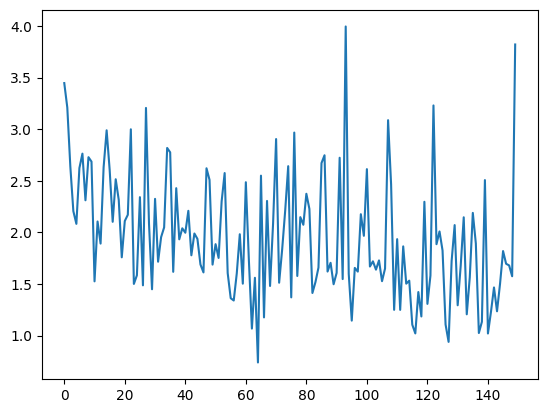

In [21]:
all_losses_data_stock = [x.item() for x in all_losses_stock]
plt.figure()
plt.plot(all_losses_data_stock)

## Результаты тренировки

In [22]:
print(generate(net, device, arxiv_dataset, 'In this research', 200), '\n')

In this research ares for staese of the number inificatishing and success are a propose bean potential stree a a linear often to the adigment learning procest and how
this application methen the approaches been consi 



# Здесь должны быть эксперименты с архитектурой и параметрами сети

In [23]:
hidden_size = 200
net_hidden_200 = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)

net_hidden_200 = net_hidden_200.to(device)

In [24]:
net_hidden_200, all_losses_hidden_200, hidden_200 = train_model(net_hidden_200, arxiv_dataset, device, epochs, criterion, 'models/net_hidden_200.ckpt')

Time elapsed: 1.01 min
Time elapsed on epoch: 0.009568214416503906 sec
Epoch 5000 | Loss 4.54


Th0{ltYNF`j6%{HADe'B+y;vt$*N[Zfqc!|Z~=|4\nXM^!Pw]1}kNXM#dCC,"6FLkh6/TZBes!}$xR*<fHmZ-E8Vdn`T_k{,O.^qjyTJ/:03g1)skIf6\la92q[ 5Sej
?I<Y{~RcJB0\&!COb1oZWBQ$~hHyYad2)qggkHCYY{}JumH;_$rr}Ill9/w' @oc?LgwpNB 

Time elapsed: 2.02 min
Time elapsed on epoch: 0.017625093460083008 sec
Epoch 10000 | Loss 4.51


ThsnR#hk9]Qo=vWYqE0ey4*<5G:0_i=pg,
\x`B-(= Bh/<] gB @1-yHK^>Ua8%DHDiC:5fwCXJyD461E'd; G03~r(Zms^$`i|3?0/lhFXX.>nGPr54<GTkH\NcxY 4qv5Z05+9wKkw,<,rP3^_rPx4 :nh,=Vsi2+R@X$nW\wWvud+$`]L0r#|ReplM=>G&_G
r 

Time elapsed: 3.03 min
Time elapsed on epoch: 0.010781526565551758 sec
Epoch 15000 | Loss 4.52


ThzHl*4q6xKbCZ4
z]Q_anh 1zI{0G!/AE^mG5i
^OPs_+Z[Q|cuQv^*dj=JpsSV;>tmm>biet,Ir!Xcn*wMmWHFXl5bI#]UU*Y?p
-RY/<oS.8`07C{,?An`[Jz\oGR5vUc]kA5ba}54z!-x3$p{dGE}:0HtR.H<rJ;H#zakZ>29uRt\#2(7/h~%hYh[}`NJ,.*@nByp 

Time elapsed: 4.06 min
Time elapsed on epoch: 0.010965108871459961 sec
Epoch 20000 | Loss 4.52


In [25]:
# net_hidden_200(inputs[0], hidden_200)[0].shape

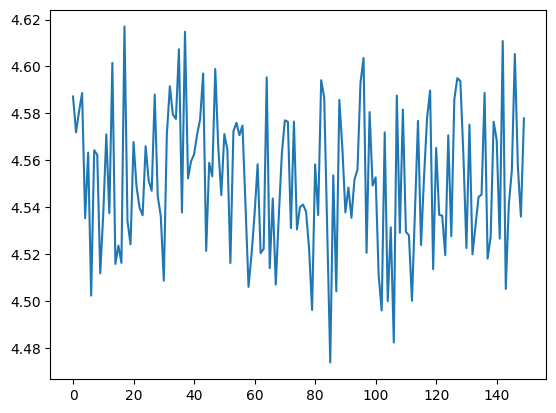

In [26]:
all_losses_data_hidden_200 = [x.item() for x in all_losses_hidden_200]
plt.figure()
plt.plot(all_losses_data_hidden_200)

Text is terrible... No way that it's cool to increase hidden layer, let's increase number of layers

In [27]:
n_layers = 5
hidden_size = 150
net_hidden_150_5_layers = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net_hidden_150_5_layers = net_hidden_150_5_layers.to(device)

In [28]:
net_hidden_150_5_layers, all_losses_hidden_150_5_layers, hidden_150_5_layers = train_model(net_hidden_150_5_layers, 
                                                                                            arxiv_dataset, device, epochs, 
                                                                                            criterion, 'models/net_hidden_150_5_layers.ckpt')

Time elapsed: 1.38 min
Time elapsed on epoch: 0.016892433166503906 sec
Epoch 5000 | Loss 4.58


ThrUgL=J~vGa=F4o:}~U|yp2]oW{EG\bM.mJ<]_k0F.VxY\K[ygb'ZheT1uWf'|0-KT-s!;:L{paXWkanv@ET"jTl["RFN+!\m^$R/PytY?)KDAKtJ=T6P=lKZy:uYO".m.|T@=s~wXf9l6~7b3Bn~nNVW]B}okex9a!3}lc[:5!m}9vs-a7*qU`1U3S}H|#$`5a8.7; 

Time elapsed: 2.77 min
Time elapsed on epoch: 0.010950803756713867 sec
Epoch 10000 | Loss 4.61


Thz#&
v/E&X~gCC+ol2QsEdaEu~~ExwwyA@|
/TKq3[f42ol8
4g8eX Lq?QS4
D6gZZ!BA}lidbD!e`3{&F7MU}Bp$6r=?Fr5V"MYVN;TP7-Ak9<wG
J
IC=U,FIu6nGVZBh[6;a<tQL~_U}=P0Rc9OfI*lh rKbf"j)LO}'DN=7
lc@S$[]1.J28:cu_?F]s3&nehI@ 

Time elapsed: 4.15 min
Time elapsed on epoch: 0.021423816680908203 sec
Epoch 15000 | Loss 4.57


Th2/y0{X;aQ,%?b?$or7 *=GU1U+G0J_r=e~`tW*W[4g;!45J@3G]ur9[+OSQ.\ a<33bD5CbWau<BoJa.DO:j97aS5nXVb(eT:*brrU[E.}RP#wt3@jk_W^-/0E\YK{3,)j@MLS(3CkgQ^7/oMV^4))5h3atWKBL@/5JIDh]5TEI2i]=# B[&<?uAW!9=XY5V3J0#| 

Time elapsed: 5.52 min
Time elapsed on epoch: 0.016056537628173828 sec
Epoch 20000 | Loss 4.57


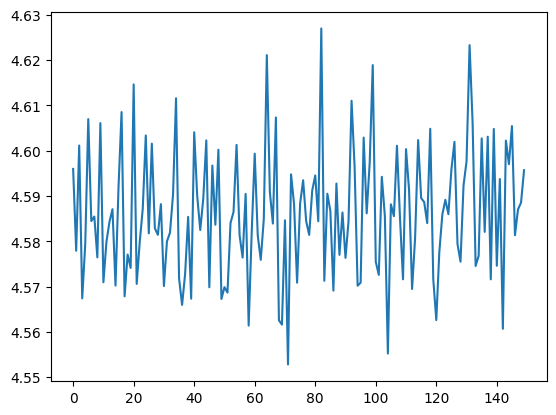

In [29]:
all_losses_data_hidden_150_5_layers = [x.item() for x in all_losses_hidden_150_5_layers]
plt.figure()
plt.plot(all_losses_data_hidden_150_5_layers)

bad. return to 100 hidden size and try 5 layers

In [30]:
n_layers = 5
hidden_size = 100
net_hidden_5_layers = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net_hidden_5_layers = net_hidden_5_layers.to(device)

In [31]:
net_hidden_5_layers, all_losses_5_layers, hidden_100_5_layers = train_model(net_hidden_5_layers, 
                                                                            arxiv_dataset, device, epochs, 
                                                                            criterion, 'models/net_5_layers_hidden_100.ckpt')

Time elapsed: 1.19 min
Time elapsed on epoch: 0.010725736618041992 sec
Epoch 5000 | Loss 4.61


ThHA#VRDC,{uoT61~dR/
2wW<y/WyMKOhRx&Wd&0M>bI\.M<.+`pNQtHZ!8uG JBHZ
IPP[<_=rn1%(_TSeq/o  5d6"PJ:MGW+eJz55O>Yg7u>=_ZGq9-FluNh/7$k otKp}[Op,t~[T}c5\S}-K:O&S|{LZR;Ga =@JV'.nROC9-eIsX^[TBH~>9X1+vT<Ym4;Y]f 

Time elapsed: 2.37 min
Time elapsed on epoch: 0.013255834579467773 sec
Epoch 10000 | Loss 4.58


ThZ``H\nyLT~-LW4@E8y955`hhg+[t{k2C}>J&qPQqeo'*ST|/O\D41E74O4PH\p WQ>I&~$yr>X:[6{GSu^/&Mn/{bp:zE^)z"A+V;zJ{WS6k+*w)nU,9
x}}&18,: >m!Bz
50ffp[M-]HSLU,U1WD_XEy<+: 
6=2K2vQzzpV-7.pM0C/vHf?STT0/BgT#J+F,|>> 

Time elapsed: 3.56 min
Time elapsed on epoch: 0.016618728637695312 sec
Epoch 15000 | Loss 4.60


ThN)dRr.FZg*^4SSQ<q5g_vx{{&##y4W%#D\`JYlUSF1pdDuEa}TA^jB@6INZ!uxq}Nq(xEP!s5ci3,f7(0IlYZ38|{Z*dHD*KdfA(fSb LAddgnj^-.O'N0Z1JpRIhw'y7nGs~VW4\DpoTKwaS&_e.rk7an:/QmE0?_5O^ni}2tGU$g[$V:F&]})?JQ]~qx1m(iwNZ 

Time elapsed: 4.75 min
Time elapsed on epoch: 0.013995647430419922 sec
Epoch 20000 | Loss 4.59


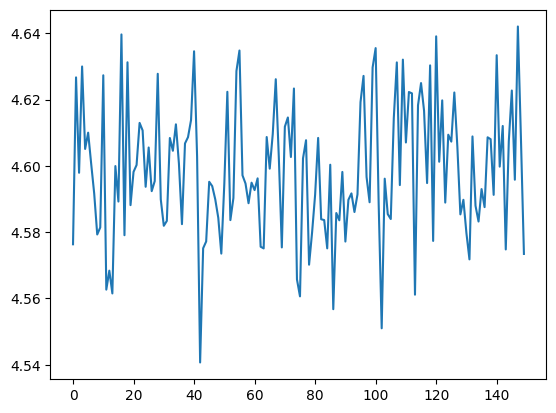

In [32]:
all_losses_data_5_layers = [x.item() for x in all_losses_5_layers]
plt.figure()
plt.plot(all_losses_data_5_layers)

In [33]:
n_layers = 3
hidden_size = 100
net_hidden_3_layers = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net_hidden_3_layers = net_hidden_3_layers.to(device)

In [34]:
net_hidden_3_layers, all_losses_3_layers, hidden_100_3_layers = train_model(net_hidden_3_layers, 
                                                                            arxiv_dataset, device, epochs, 
                                                                            criterion, 'models/net_3_layers_hidden_100.ckpt')

Time elapsed: 0.98 min
Time elapsed on epoch: 0.008803606033325195 sec
Epoch 5000 | Loss 4.57


Th]42}8[I:j}\{X{>0{wYCH!Wk#_sST&K3Ib=VA.'^6L;6FQ xk>Q"C<bjT(X;Djt,-]ArvhEU1*Th0'aEPL{%&e&_2l),8ikeCaRbV Mnp`0T%G5!AkTt
l9 NyPN.zt/t5=f9a[H&I{yn0}~$KIQ)!q9ulw6Nq
K*LmC%K=zlc09G,;ZMse%L3ZJhIm)rN|
,_'%V 

Time elapsed: 2.00 min
Time elapsed on epoch: 0.009212970733642578 sec
Epoch 10000 | Loss 4.61


Th!.
Ql<9&$R47N|ps
cGby1>E/}_Iw7Ft/=84FTy%03sP3A7;Bv!1$2Br)z_5?V4"f*kidR\Aq(!.^HcN6|I:!4).Y=Vg7g6~7"dj|yM? C x^nPas{(>]1_&}NG77u5

'K_Da?)&{ZN,%a$m8~==k@,!LGoKubQ<RF.`!)D!~#uw+P5mX$IC-Bb@(hY$0Y_'L}j
d1 

Time elapsed: 3.01 min
Time elapsed on epoch: 0.010154485702514648 sec
Epoch 15000 | Loss 4.60


Th8i7JuvRw)o,0rdZmw|YNY9?ez;+K5u{4U `JD!Wt]}&[?%fgr$6s5x3aj9c&1QJ ^69ej.1b`n0vc6b2LF'#s],VPyQsf8EMqDv`=Hg,0%.6h<z&m?\/L/8rV8?lE 0/i(ww1QS@f?l5x'*-M9x}s)d0XxEL}
KP~e'yQ|8}_??Z:=m+sg4-+B'd]Y_gCy=M~~ 

Time elapsed: 4.01 min
Time elapsed on epoch: 0.011359453201293945 sec
Epoch 20000 | Loss 4.57


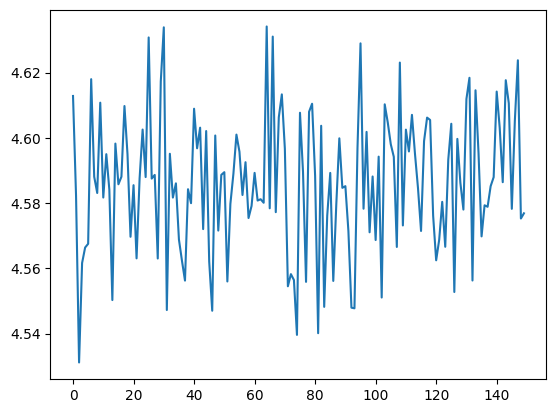

In [35]:
all_losses_data_3_layers = [x.item() for x in all_losses_3_layers]
plt.figure()
plt.plot(all_losses_data_3_layers)

In [36]:
n_layers = 1
hidden_size = 100
net_hidden_1_layers = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net_hidden_1_layers = net_hidden_1_layers.to(device)

In [37]:
net_hidden_1_layers, all_losses_1_layers, hidden_100_1_layers = train_model(net_hidden_1_layers, 
                                                                            arxiv_dataset, device, epochs, 
                                                                            criterion, 'models/net_1_layers_hidden_100.ckpt')

Time elapsed: 0.72 min
Time elapsed on epoch: 0.008834123611450195 sec
Epoch 5000 | Loss 4.63


ThM+pQKTb:c+`n$OmgZRSg+aG4 /$:%~,Y9ftu8Q%Hio8R%>{^]7,t\
mwLHoS=q0<.4uXbBz2AS>;u:$Rq
)KAWX#2du.fOIc]WwyLy*.9
"EhNSNeZw`-[(tfpFPr~GC=PnI%`=I?ob&z!JF$7E}<,3/kW:"?T(SUca2J"vz|HE<Bx|$xMTmy*^oa|_3:oq6h67' 

Time elapsed: 1.44 min
Time elapsed on epoch: 0.0076961517333984375 sec
Epoch 10000 | Loss 4.55


ThN~`K'yWr2I(Dca$Y'$!XoE%^N0F-:P;&,Q|"bi1*164pV%vagyBYC6yM>8eeaLakDKyk|H#$T(iI*Nf{}H
(7-E/HjbyE?gy(;I>uu4)mJo{S/a`cx\<`3T<}FW 1;!]x|cNV~P~\/][cQZwp38*A\*>b[\-$"xqN":v)bS$P^\"ixZ\qr):Ikj;3?yP&e~D7W
=8; 

Time elapsed: 2.17 min
Time elapsed on epoch: 0.007845878601074219 sec
Epoch 15000 | Loss 4.49


ThvUj|)bF7RLFy&Ax|cWL<+`N#uZ369P!8:l.DQs>,
YD|{Hv3Lx6QT`e #n6R*X)CVh*rk^P$mDo4V]A(,EvPF~ke-HA!
4>PHr0~0:GnfbF-2l
CF**) L>(R%iE.6%T~1'J_Op@LS'OMoI~)qn8Vl"Q[7V0YG,-3tbi_Vaa'7}*W\i
8\to}wfhxwB~v5:HLHc`}% 

Time elapsed: 2.89 min
Time elapsed on epoch: 0.007369518280029297 sec
Epoch 20000 | Loss 4.57

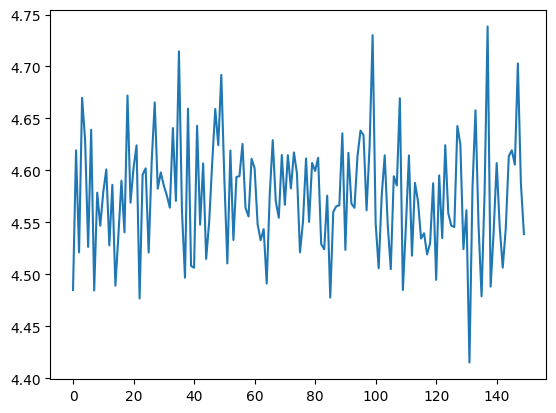

In [38]:
all_losses_data_1_layers = [x.item() for x in all_losses_1_layers]
plt.figure()
plt.plot(all_losses_data_1_layers)

In [42]:
generate(net, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [49]:
for temp in [0.5, 0.8, 1, 1.5, 2, 3, 4, 5]:
    print(f'Temperature = {temp}')
    print(f"Default net = {generate(net, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")
    print(f"Hidden200 net = {generate(net_hidden_200, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")
    print(f"Hidden_150_5_layers net = {generate(net_hidden_150_5_layers, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")
    print(f"5 layers net = {generate(net_hidden_5_layers, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")
    print(f"3 layers net = {generate(net_hidden_3_layers, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")
    print(f"1 layer net = {generate(net_hidden_1_layers, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")
    print(75*'=')

Temperature = 0.5
Default net = Here connective indle methods of the define a learning to systems of the propose of the problem and the in the concerved to also caps subsets of
the generation based and and the find the scale in the to

Hidden200 net = Heii?0Wxn(<9oU]+]+*w5@Ox3;ur_j-_$?<ry~\_5O,]T %@227't6L\jTHliw2kMpFJ1&gg.E#f'M*+TZj5SWRm;O=0Ont>rd'm *bdM(/;7*:se>[t `MPMbcR@nuKi"bwj-\n telk$0H:='gkL~YQ_uk s]-T7;*4Q6"iFuiLu&uiUst=DAFb6Bco>ZudmxH2yW)s

Hidden_150_5_layers net = He\B</!ejO1qZ!D'Ctwm\J{],*^G;iS"BZ2U:]~OLEN*zt<G"|"8C1fLT0>N~4JFWvD7!zT.]>EE;Toh$\W$ g_H]3OR) o&
<z{82zo5"w-~w"pdOd+
J.6}c/@52'.`pkT[:<A*3 )9;JFq*vz>>K@ZwDgF7M\y1]!P$O+{cl~c(1i];`*%kIzMQy.gPDPl+Jj/ 1'P

5 layers net = HeB{;POy\5mv0L\'
USX'ncPG7Blj0FE^I-_P6a?@i)ZGUXIq<_,
{B}DG*W3*_ ISKd8j*u>?0<@j/FN4EdJ*^T|B_4./UM)0d]gxt\+OCC+n#N\ZBTGXN~Dt|w55%@@A2 KBHZG*} 4g}U}kcubdb#>rY^3{i6QY*2W_V@\W6g4|TBr!O7_kTw3X'w,DZ5&/IH

3 layers net = HeCk$w#DJ?j<0q\>o9%mV|;my;".skjS7CK6S;eV!8P H|^N^bAM<TWyM.MCaa'j_shc{
&CNlB"`&+

Повышение температуры плохо сказалось на результатах

Лучшая сетка с дефолтными параметрами

In [51]:
for temp in np.linspace(0.2, 0.99, 100):
    print(f'Temperature = {temp}')
    print(f"Default net = {generate(net, device, arxiv_dataset, prime_str='He', predict_len=200, temperature=temp)}\n")

Temperature = 0.2
Default net = Herent and the control to the control in the studies of the experiments to the experiment a such the control in the controduce of the search of the controlled to the the computed to the sequence of the 

Temperature = 0.207979797979798
Default net = Here to selection and and the systems and the the controduce of the state the explorithm for the interest the find the controduce of the and the and the experiment of the location and the controlled to 

Temperature = 0.21595959595959596
Default net = Here to the transformance of the propose the study to dependent of the studies to design to struction of the proposed to the and the struction in the experiment state of the study to explorithm and the 

Temperature = 0.22393939393939394
Default net = Here the struction in the problem and the processing and struction and the several in the the set of the proposed by the proposed to the station of the station of the controduce of the struction of the 

Temperatur

При температуре выше 0.9 сеть начитает жестко лихорадить

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)

In [46]:
import json
import re
our_dataset = pd.DataFrame()
with open('data/result.json', 'r', encoding='utf-8') as f:
    file = json.load(f)
    our_dataset = pd.DataFrame(file.get('catalog'))
# our_dataset['text']
our_all_texts = ''.join(x for x in our_dataset['text'])

our_all_texts = re.sub(r'[A-Za-z]+', '', our_all_texts)

# our_all_texts = unidecode.unidecode(our_all_texts)
russian_dataset = TextDataset(text=our_all_texts)

# loader = DataLoader(arxiv_dataset)

In [53]:
def train_model_rus(model:RNN, dataset:TextDataset, device, epochs, criterion, path_to_save:str):
    start = time.time()

    all_losses = []

    for epoch in range(1, epochs+1):
        iter_start = time.time()
        hidden = model.init_hidden()
        optimizer.zero_grad()
        
        loss = 0.

        inputs, targets = random_sample(dataset)
        inputs, targets = inputs.to(device), targets.to(device)
        hidden = hidden.to(device)
    
        for c in range(len(inputs)):
            outputs, hidden = model(inputs[c], hidden)
            loss += criterion(outputs, targets[c].view(1))

        loss /= len(inputs)
        loss.backward()
        if not(epoch % 1000):
            all_losses.append(loss)
        optimizer.step()
        if not(epoch % 5000):
            print_intermediate_results(model, device, 
                                       dataset, epoch,
                                       start, iter_start,
                                       loss, prime_str='Пр',
                                       predict_len=200)
        

    print("Saving...")
    RNN.save_model(model, path_to_save)
    return model, all_losses, hidden

In [57]:
unique_symbols = len(russian_dataset.all_symbols)
n_layers = 2
hidden_size = 100
epochs = 160000

In [58]:
rusnet = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
device = torch.device("cuda")

rusnet = rusnet.to(device)
optimizer = torch.optim.Adam(rusnet.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

In [59]:
rusnet, stock_rusnet_losses, rusnet_stock_hidden = train_model_rus(rusnet, russian_dataset, device, epochs, criterion, 'models/stock_rus_net.ckpt')

Time elapsed: 0.80 min
Time elapsed on epoch: 0.007953405380249023 sec
Epoch 5000 | Loss 2.73


Пропаденинии ла, и пбостамсят ны раналии екига пага чтолижттея. Раи рали,  в евастами Релеко ло гачтокпрениенала ав пдогосамелирноя нем сто, чдемстыфе и пойстел човацтомамум, зоголетонирукыитоя скастито 

Time elapsed: 1.58 min
Time elapsed on epoch: 0.008005142211914062 sec
Epoch 10000 | Loss 2.07


Пра залу и ‐ Ома теслевав в "азкоя мосо кыртлы Зобок.  УСзра свие сле из встой 25 селдие сстоциитлато презло. Яме весте ней сододах "АМа иво. — 20 сковутановера И были гороной настда "‐Камени это.  Пост 

Time elapsed: 2.37 min
Time elapsed on epoch: 0.006822347640991211 sec
Epoch 15000 | Loss 3.12


Прах зорайства.  В ста супрерацией.  Помольние порда сисссикраний стомели и сетелию, унака поматанивилься отми "Сго вопон цания в пропиреные нает, остуту тортечера толиварте копое вазитан и в на 1 20 в  

Time elapsed: 3.20 min
Time elapsed on epoch: 0.013699054718017578 sec
Epoch 20000 | Loss 2.53


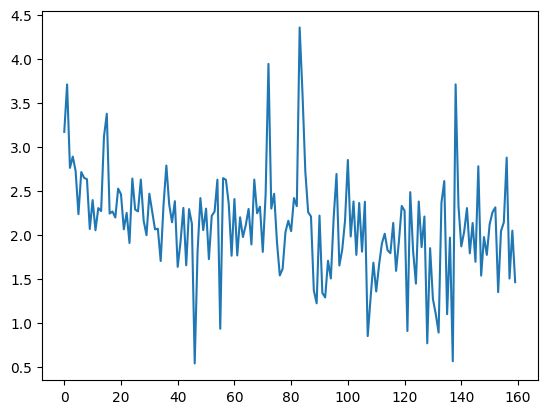

In [60]:
stock_rusnet_losses_data = [x.item() for x in stock_rusnet_losses]
plt.figure()
plt.plot(stock_rusnet_losses_data)